In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5,5,0.25)

In [5]:
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [6]:
ys = f(xs)

In [7]:
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

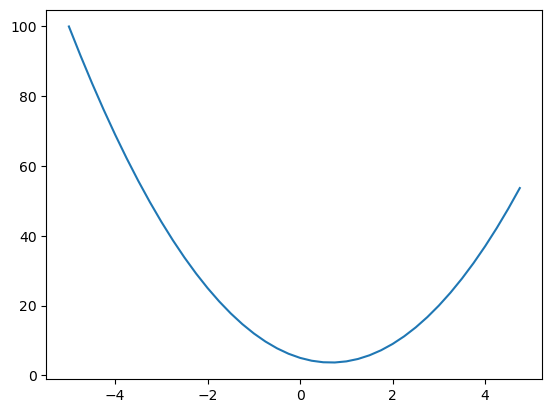

In [8]:
plt.plot(xs, ys)

In [9]:
h = 0.00000001
x = 2/3
(f(x+h) - f(x))/h

0.0

In [161]:
class Value:
    def __init__(self, data, _children = (),  _op = '', label = ''):
        
        self.data = data
        self._op = _op
        self.grad = 0
        self.label = label
        self._backward = lambda: None
        self._prev = set(_children)
        
    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other): #other *self
        return self+other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other): #other * self
        return self*other
    
    def __truediv__(self,other):
        return self*other**-1
    
    def __rtruediv__(self,other): #other / self
        return other*self**-1
    
    def __neg__(self):
        return self*-1
    
    def __sub__(self,other):
        return self + (-other)
    
    def __rsub__(self, other): #other - self
        return other+ (-self)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting'
        
        out = Value(self.data**other, (self,),f'**{other}')
        
        def _backward():
            self.grad += other * self.data **(other-1) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            visited.add(v)

            for child in v._prev:
                if child not in visited:
                    build_topo(child)

            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in topo[::-1]:
            node._backward()
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out


In [11]:
from graphviz import Digraph

In [12]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label ='{%s | data %.4f | grad %.4f }' % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node (name = uid + n._op, label = n._op)
            # and connect this node to it
            dot. edge(uid + n._op, uid)
    for n1, n2 in edges:
    # connect nl to the op node of n2
        dot. edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [13]:
draw_dot(L)

NameError: name 'L' is not defined

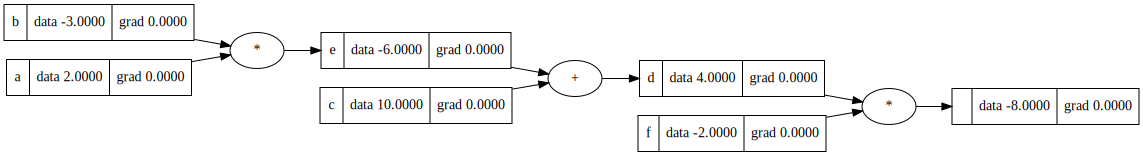

In [14]:
 a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f

L1 = L.data
draw_dot(L)




In [15]:
def lol():
    h = 0.001
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f
    
    L1 = L.data
    draw_dot(L)
    
    a = Value(2.0 , label = 'a')
    
    b = Value(-3.0, label = 'b')
    b.data+=h
    c = Value(10.0, label = 'c')
    
    e = a*b; e.label = 'e'
    
    d = e+c; d.label = 'd'
    
    f = Value(-2.0, label = 'f')
    L = d*f
    
    L2 = L.data
    
#     print((L2-L1)/h)
    
    
lol()

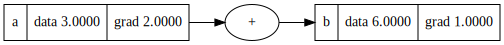

In [16]:
a = Value(3.0, label='a')
b = a+a; b.label = 'b'
b.backward()
draw_dot(b)

In [17]:
import torch

In [18]:
x1 = torch.Tensor([2.0]).double();  x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();  x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();  w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();  w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double();  b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print(' --- ')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
 --- 
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [126]:
import random

class Neuron:
    def __init__(self, n):
        self.w = [Value(random.uniform(-1,1)) for _ in range(n)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        activation = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = activation.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
    
class MLP:
    def __init__(self, n_in, n_out):
        sz = [n_in] + n_out
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_out))]
        
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])

n(x)

Value(data=0.6151643031970514)

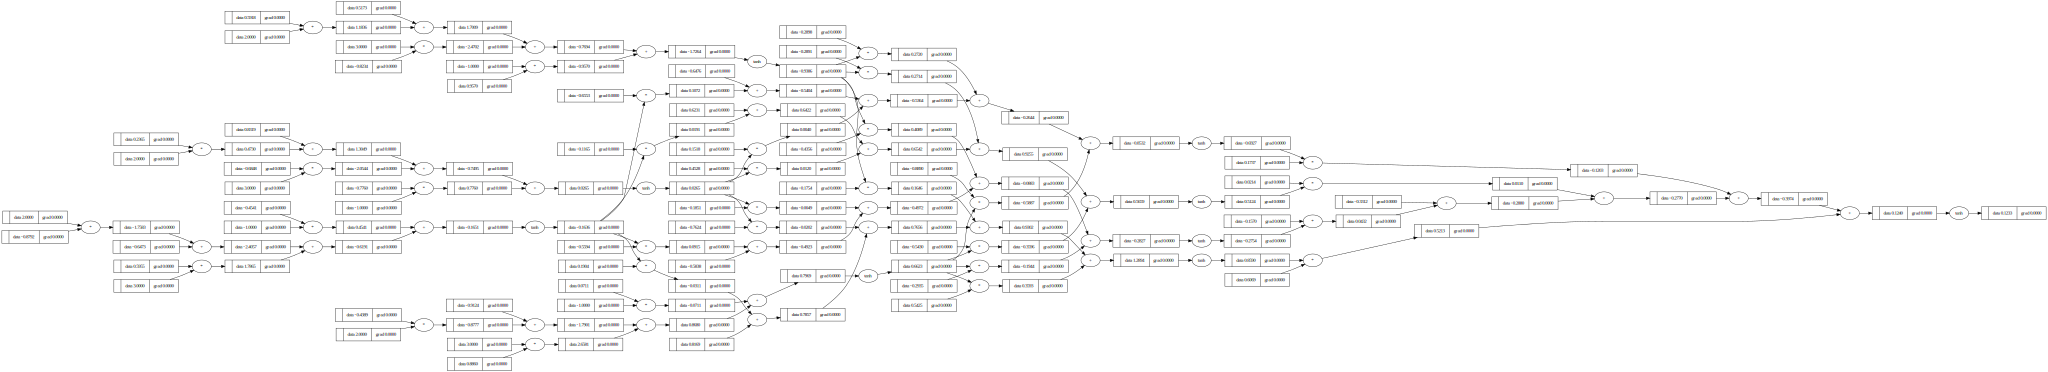

In [60]:
draw_dot(n(x))

In [127]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]


In [159]:
epoch = 20
for k in range(epoch):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    #backward propagation
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #update weights
    for p in n.parameters():
        p.data -= 0.01 * p.grad 
    
    print(k, loss.data)

0 0.0012508844438482818
1 0.0012500644102464507
2 0.0012492454448861357
3 0.001248427545693318
4 0.001247610710599323
5 0.0012467949375408209
6 0.0012459802244597516
7 0.0012451665693033942
8 0.0012443539700242446
9 0.001243542424580107
10 0.0012427319309339857
11 0.001241922487054143
12 0.0012411140909140222
13 0.0012403067404922656
14 0.0012395004337726822
15 0.0012386951687442596
16 0.00123789094340108
17 0.0012370877557424257
18 0.0012362856037725863
19 0.001235484485501036


In [160]:
ypred

[Value(data=0.9959515747368677),
 Value(data=-0.988493537993716),
 Value(data=-0.9743278319679284),
 Value(data=0.9793206417164146)]

In [64]:
n.layers[0].neurons[0].w[0].grad

-0.3456533218402533

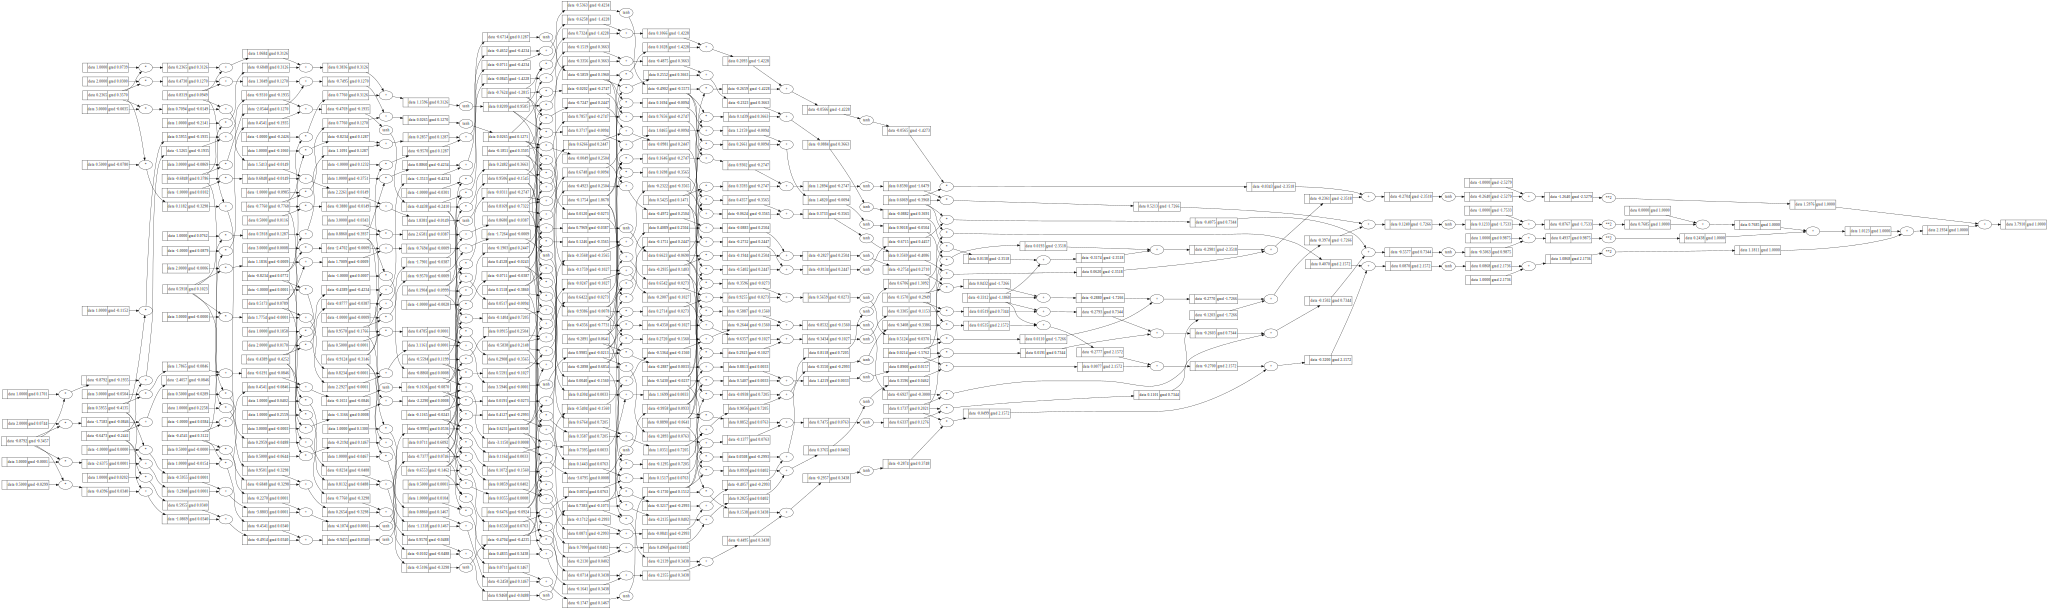

In [65]:
draw_dot(loss)

In [66]:
n.parameters()

[Value(data=-0.8791630102290595),
 Value(data=0.5955071528684386),
 Value(data=-0.45408340274981684),
 Value(data=-0.6473399850763177),
 Value(data=0.23648011553822634),
 Value(data=-0.6847870661195836),
 Value(data=-0.775993156949565),
 Value(data=0.8319017057728819),
 Value(data=0.5918016021873076),
 Value(data=-0.8234127503656534),
 Value(data=0.9570302598841451),
 Value(data=0.5172753045551837),
 Value(data=-0.4388731477574175),
 Value(data=0.8860280014565343),
 Value(data=0.07105932593754649),
 Value(data=-0.9123830183345518),
 Value(data=-0.5594070712921442),
 Value(data=-0.18505692165752508),
 Value(data=-0.4356470808051818),
 Value(data=-0.2935154873127477),
 Value(data=-0.5838464162289592),
 Value(data=-0.11645825170395319),
 Value(data=0.45280660373884163),
 Value(data=-0.2891159103375607),
 Value(data=-0.5429632210258013),
 Value(data=0.6231066627987636),
 Value(data=-0.655341020392862),
 Value(data=0.1517802627565874),
 Value(data=-0.28977000560541843),
 Value(data=-0.88895

In [69]:
n.layers[0].neurons[0].w[0].data

-0.875706477010657

In [117]:
loss.backward()

In [118]:
for p in n.parameters():
    p.data -= 0.01 * p.grad 

In [119]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.01891233004441861)

In [120]:
ypred

[Value(data=0.906721977297483),
 Value(data=-0.9519705721287873),
 Value(data=-0.9668006196575499),
 Value(data=0.9175226350544062)]

# Summary

This Micrograd tiny project implements the functionality of Multi Layer Perception, more specifically, through constructing the Value class as Neurons, it implements the automatic gradient computation for Neuron which backpropage the gradient along the DAG built upon the expresssion tree.